## Documentation to support the publication: Updating the US National Fire Danger Rating System

### Purpose: Run the NFDRSV4 command line interface and compare outputs to fire activity

<font size=5>RunNFDRSLoloEval.ipynb</font><br>
Patrick H. Freeborn, patrick.h.freeborn@usda.gov<br>
W. Matt Jolly, matt.jolly@usda.gov<br>
USDA Forest Service<br>
RMRS Fire Sciences Laboratory<br>
Fire, Fuel and Smoke Program<br>
5775 Hwy 10 W<br>
Missoula, MT 59808<br><font size=5>

# Introduction
This notebook contains an example of how Version 4 of the United States National Fire Danger Rating System (USNFDRS) is evaluated, as presented in the manuscript. Specifically, this notebook:

(1) Demonstrates how to use the command line interface (CLI) to perform USNFDRS calculations for a time series of observations recorded at single Remote Automated Weather Station (RAWS),

(2) Briefly explains the concept of a special interest group (SIG),

(3) Briefly explains the concept of "Fire-Days" and demonstrates how to transform historical fire occurrence data into a daily time series of "0's" and "1's" that can be used for evaluation,

(4) Demonstrates how to synchronize time series of daily fire danger and fire-days, and how to use the receiver operating characteristic (ROC) curve and its integral, the area under the curve (AUC), to quantitatively evaluate the ability of USNFDRS Version 4 to predict new wildland fire activity.

# Set-up

In [1]:
import os
import subprocess

import pprint
pp = pprint.PrettyPrinter()

from IPython.display import display, HTML # enable horizontal scrolling for wide dataframes
display(HTML("<style>.jp-OutputArea-output {display:flex}</style>")) # enable horizontal scrolling for wide dataframes
from IPython.display import Image 

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 20)
from pandas.tseries.offsets import DateOffset

from sklearn import metrics

from src.NFDRSV4PubGraphicsOptions import *

# CLI

## Description
Via a command line interface (CLI), the NFDRS executable (RunNFDRS.exe) only requires a configuration file as input (details here: NFDRS4/doc/NFDRS4_cli_Configuration_File.pdf). For this excercise, the configuration file is named "Lolo241513YConfiguration.cfg". The configuration file points to two other files:<br>
(1) A comma separated value (CSV) fire weather file in FW21 format (details here: NFDRS4/doc/FW21_Fire_Weather_Format.pdf). For this excercise, the FW21 file is named "Lolo241513metFW21.csv".  
(2) An initialization file that sets up the NFDRS model (details here: NFDRS4/doc/FW21_Fire_Weather_Format.pdf). For this excercise, the initialization file is named "Lolo241513YInitialization.cfg".

There are three output options that can be specified in the congiguration file (details here: NFDRS4/doc/NFDRS4_cli_Configuration_File.pdf). Also in the configuration file there is the option of setting the output interval to either hourly or daily. For this excercise, daily indices at the standadard observation hour (1300, specified in the model initialization file) are output to file named "Lolo241513YIndexOutput.csv".

In the filenames, the term "Lolo" refers to the evaluation site, the Lolo National Forest (NF). The term "241513" refers to the weather station ID for the Blue Mtn. RAWS, located in the Lolo NF, and the term "Y" refers to fuel model Y. 

In [2]:
Image(url="docs/NFDRSv4_CLI_Flowchart.png", width=900, height=900) 

## Usage

### Note: RunNFDRS.exe is compiled for MS Windows 10. The source code is available to build this interface on any platform and you can find the source code here: https://github.com/firelab/NFDRS4

In [4]:
filename_exe = 'tools/RunNFDRS.exe'
filename_configuration = 'data/Lolo241513YConfiguration.cfg'
cmd_CLI = [filename_exe, filename_configuration]
cmd_CLI_return = subprocess.run(cmd_CLI)
pp.pprint(cmd_CLI_return)

CompletedProcess(args=['tools/RunNFDRS.exe', 'data/Lolo241513YConfiguration.cfg'], returncode=0)


## Inspect index outputs

In [5]:
filename_indexOutput_241513 = 'data/Lolo241513YIndexOutput.csv'

### read in

In [6]:
df_Lolo_24513_indexOutput_obsHour = pd.read_csv(filename_indexOutput_241513) # read into pandas datafram
df_Lolo_24513_indexOutput_obsHour.rename(columns=lambda x: x.strip(), inplace=True) # remove spaces at the beginning and at the end of the column names
df_Lolo_24513_indexOutput_obsHour['DateTime']=pd.to_datetime(df_Lolo_24513_indexOutput_obsHour['DateTime'].astype(str)) # format dtype
df_Lolo_24513_indexOutput_obsHour = df_Lolo_24513_indexOutput_obsHour[df_Lolo_24513_indexOutput_obsHour['DateTime'].dt.year >= 2003].reset_index(drop = True) # from 2003 onwards.
df_Lolo_24513_indexOutput_obsHour['DateTime'] = df_Lolo_24513_indexOutput_obsHour['DateTime'].dt.date
df_Lolo_24513_indexOutput_obsHour.set_index('DateTime', inplace = True, drop = True)
df_Lolo_24513_indexOutput_obsHour.index.rename('Date', inplace = True)

# change index names in columns to capture the fuel model
list_old_names = ['BI', 'ERC', 'SC', 'IC']
list_new_names = [s + '_Y' for s in list_old_names]
dict_old_new_index_names = {list_old_names[i]: list_new_names[i] for i in range(len(list_old_names))}
df_Lolo_24513_indexOutput_obsHour = df_Lolo_24513_indexOutput_obsHour.rename(columns=dict_old_new_index_names)

### Plot ERC(Y)
* daily time series of Energy Release Component (ERC) fuel model Y for 2012

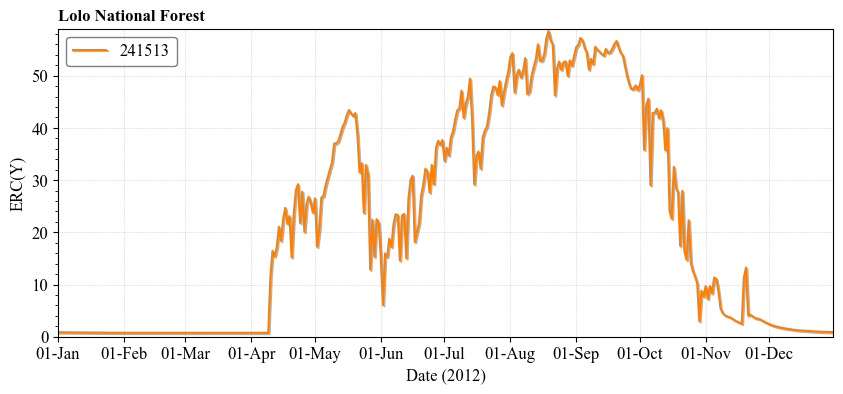

In [7]:
Variable = "ERC_Y"
VariableLabel = "ERC(Y)"
single_RAWS_label = '241513'
title_eval_site = "Lolo National Forest"

f,ax = plt.subplots(figsize=(10, 4))
ax.plot(df_Lolo_24513_indexOutput_obsHour[Variable], color = clr_nf5, linewidth = 1.5, path_effects=[PathEffects.SimpleLineShadow(offset=(1.0, -1.0)),PathEffects.Normal()], label = single_RAWS_label)
plt.legend(loc = 'upper left');
plt.grid(color='grey', linestyle=':');

ax.set_xlim([date(2012, 1, 1), date(2012, 12, 31)]);
date_form = mdates.DateFormatter("%d-%b")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))

ax.set_xlabel("Date (2012)");
ax.set_ylim([0,59]);
ax.set_ylabel(VariableLabel);
ax.set_title(title_eval_site, loc='left');

plt.show();

## Lolo NF SIG
Rather than usig a single weather station, daily fire danger across the Lolo NF is captured with a collection of several RAWS (see Figure 6B in the journal article). A special interest group (SIG) consisting of five individual RAWS was created for the Lolo NF. For each RAWS in the SIG, fire weather files, model initialization files, and configuration files were constructed and used to generate five separate daily time series of fire danger components and indexes from the CLI. Each weather station was weighted equally and daily time series for the SIG were calculated by averaging fire danger components and indexes (at the standard observation hour) over all RAWS. For this excercise, these steps were performed ahead of time and were output to a file named "LoloSIGYIndexOutput.csv".   

In [8]:
filename_indexOutput_SIG = 'data/LoloSIGYIndexOutput.csv'

In [9]:
df_Lolo_SIG_indexOutput_obsHour = pd.read_csv(filename_indexOutput_SIG) # read into pandas dataframe
df_Lolo_SIG_indexOutput_obsHour['Date'] = pd.to_datetime(df_Lolo_SIG_indexOutput_obsHour['Date'].astype(str)).dt.date
df_Lolo_SIG_indexOutput_obsHour.set_index('Date', inplace = True, drop = True)

## Plot ERC(Y)
* daily time series of Energy Release Component (ERC) fuel model Y for 2012

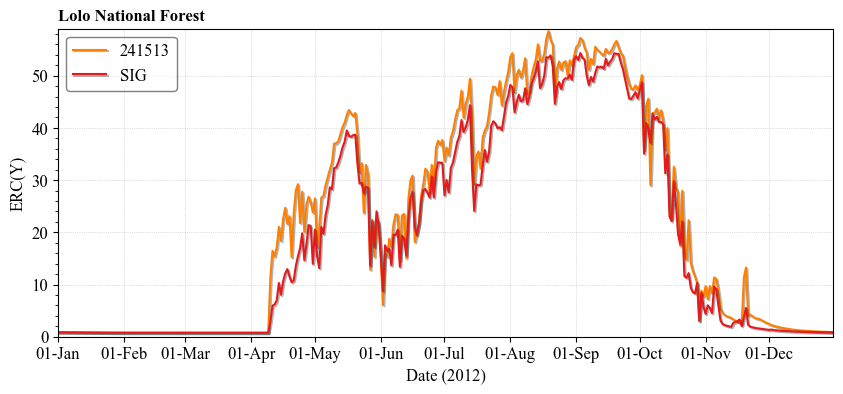

In [10]:
Variable = "ERC_Y"
VariableLabel = "ERC(Y)"
single_RAWS_label = '241513'
SIG_label = 'SIG'
title_eval_site = "Lolo National Forest"

f,ax = plt.subplots(figsize=(10, 4))
ax.plot(df_Lolo_24513_indexOutput_obsHour[Variable], color = clr_nf5, linewidth = 1.5, path_effects=[PathEffects.SimpleLineShadow(offset=(1.0, -1.0)),PathEffects.Normal()], label = single_RAWS_label)
ax.plot(df_Lolo_SIG_indexOutput_obsHour[Variable], color = clr_nf1, linewidth = 1.5, path_effects=[PathEffects.SimpleLineShadow(offset=(1.0, -1.0)),PathEffects.Normal()], label = SIG_label)
plt.legend(loc = 'upper left');
plt.grid(color='grey', linestyle=':');

ax.set_xlim([date(2012, 1, 1), date(2012, 12, 31)]);
date_form = mdates.DateFormatter("%d-%b")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))

ax.set_xlabel("Date (2012)");
ax.set_ylim([0,59]);
ax.set_ylabel(VariableLabel);
ax.set_title(title_eval_site, loc='left');

plt.show();

# Evaluation
The ability of USNFDRS Version 4 to predict new fire activity is evaluated based on the concept of "non-fire-days", "fire-days", and "large-fire-days". A non-fire-day (NFD) is defined as a 24-hr period during which no new fire activity was reported within an evaluation site. Conversely a fire-day (FD) is defined as a 24-hr period during which at least one new wildland fire was reported within an evaluation site. A large-fire-day (LFD) is defined as a 24-hr period during which at least one new wildland fire was reported and eventually exceeded a certain size threshold. Final fire size thresholds used to define a LFD are unique for every evaluation site and are set to the 97$^{th}$ percentile of the historical fire size distribution.

## fire occurrence data
 from the Fire Program Analysis Fire Occurrence Database (FPA FOD)

In [11]:
filename_FPAFOD_LoloNF = 'data/simple_FPAFOD_LoloNF.csv'

In [12]:
df_FPAFOD_LoloNF = pd.read_csv(filename_FPAFOD_LoloNF)
df_FPAFOD_LoloNF['DISCOVERY_DATE'] = pd.to_datetime(df_FPAFOD_LoloNF['DISCOVERY_DATE'].astype(str))
LFD_threhold = df_FPAFOD_LoloNF['FIRE_SIZE'].quantile(0.97)
print('Large fire threshold for the Lolo NF is ' + str(np.round(LFD_threhold * 0.4046856422)) + ' ha')

Large fire threshold for the Lolo NF is 10.0 ha


In [13]:
df_daily_max_fire_size = df_FPAFOD_LoloNF[['DISCOVERY_DATE', 'FIRE_SIZE']].groupby(['DISCOVERY_DATE']).max().rename(columns = {'FIRE_SIZE' : 'Max_Fire_Size'}).reset_index(drop = False)
df_daily_max_fire_size.set_index('DISCOVERY_DATE', inplace = True, drop = True)
df_daily_max_fire_size.index.rename('Date', inplace = True)

## Assign non-firedays, fire-days and large-fire-days
* non-fire-days are set to 0
* fire-days and large-fire-days are set to 1

In [14]:
df_daily_listing_LoloNF = df_Lolo_SIG_indexOutput_obsHour.join(df_daily_max_fire_size)
df_daily_listing_LoloNF['Max_Fire_Size'] = df_daily_listing_LoloNF['Max_Fire_Size'].fillna(0)
df_daily_listing_LoloNF['FD'] = 0
idx_FD = df_daily_listing_LoloNF['Max_Fire_Size'] > 0
df_daily_listing_LoloNF.loc[idx_FD,'FD'] = 1
df_daily_listing_LoloNF_NFD_Only_for_plot = df_daily_listing_LoloNF[df_daily_listing_LoloNF['FD']==0]
df_daily_listing_LoloNF_FD_Only_for_plot = df_daily_listing_LoloNF[df_daily_listing_LoloNF['FD']==1]

df_daily_listing_LoloNF['LFD'] = 0
idx_LFD = df_daily_listing_LoloNF['Max_Fire_Size'] > LFD_threhold
df_daily_listing_LoloNF.loc[idx_LFD,'LFD'] = 1
df_daily_listing_LoloNF_LFD_Only_for_plot = df_daily_listing_LoloNF[df_daily_listing_LoloNF['LFD']==1]

## Plot Fire-Days
* daily time series of non-fire-days, fire-days and large-fire-days for 2012

In [ ]:
Variable = "ERC_Y"
VariableLabel = "ERC(Y)"
single_RAWS_label = '241513'
SIG_label = 'SIG'
title_eval_site = "Lolo National Forest"

f,(ax0, ax1) = plt.subplots(2, 1, height_ratios=[1, 4], figsize=(10, 5))
plt.subplots_adjust(hspace=.025)

date_form = mdates.DateFormatter("%d-%b")
ax0.scatter(df_daily_listing_LoloNF_NFD_Only_for_plot.index, df_daily_listing_LoloNF_NFD_Only_for_plot['FD'], marker = '^', s = 15, c = 'g', alpha = 1, label = 'NFD')
ax0.scatter(df_daily_listing_LoloNF_FD_Only_for_plot.index, df_daily_listing_LoloNF_FD_Only_for_plot['FD'], marker = 'o', s = 15, c = 'y', alpha = 1, label = 'FD')
ax0.scatter(df_daily_listing_LoloNF_LFD_Only_for_plot.index, df_daily_listing_LoloNF_LFD_Only_for_plot['LFD'], marker = 'x', s = 50, c = 'k', alpha = 1, label = 'LFD')
ax0.legend(loc = 'center left', ncol=3, handletextpad=0.01);

ax0.set_xlim([date(2012, 1, 1), date(2012, 12, 31)]);
ax0.xaxis.set_major_formatter(date_form)
ax0.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax0.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
ax0.set_xticklabels([])
ax0.set_ylim([-.1, 1.1]);
ax0.set_yticks([0,1])
ax0.yaxis.set_tick_params(which='minor', bottom=False)
ax0.set_title(title_eval_site, loc='left');

ax1.plot(df_daily_listing_LoloNF[Variable], color = clr_nf1, linewidth = 1.5, path_effects=[PathEffects.SimpleLineShadow(offset=(1.0, -1.0)),PathEffects.Normal()], label = SIG_label)
ax1.legend(loc = 'upper left');
plt.grid(color='grey', linestyle=':');

ax1.set_xlim([date(2012, 1, 1), date(2012, 12, 31)]);
ax1.xaxis.set_major_formatter(date_form)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))

ax1.set_xlabel("Date (2012)");
ax1.set_ylim([0,59]);
ax1.set_ylabel(VariableLabel);

plt.show()

## ROC and AUCs
The ROC curve AUC objectively quantify whether a fire danger index is any better at distinguishing fire-days from non fire days compared to random guessing. In the ROC analysis, fire danger is considered
a binary classifier such that setting a single fire danger threshold splits the predictions into two classes. Days when fire danger is below the threshold are predicted as non-fire-days, and days when fire danger is above the threshold are predicted as fire-days. The ability of a single fire danger threshold to separate fire-days from non-fire days is gauged by a combination of the true positive rate (TPR) and false positive rate (FPR), where the former is the fraction of true fire-days that were correctly predicted and the latter is the fraction of true non-fire days that were incorrectly predicted. The optimal fire danger threshold has a high TPR and a low FPR. Rather than evaluating a fire danger index based on a single threshold, values of TPR and FPR are calculated over the full range of possible thresholds and plotted against each other to construct the ROC curve. Integrating the ROC curve yields the AUC. Values for the AUC near 0.5 indicate that over all possible thresholds, the fire danger index is no more useful at making predictions than random guessing. Higher values for the AUC indicate improved prediction performance, and values of AUC=1.0 indicate that the fire danger index makes perfect predictions.

### Fire-Days

In [ ]:
np_dl_index = np.expand_dims(df_daily_listing_LoloNF['ERC_Y'].to_numpy(), axis = 1)
np_dl_fire_days = df_daily_listing_LoloNF['FD']
fpr_fd, tpr_fd, _ = metrics.roc_curve(np_dl_fire_days,  np_dl_index)
np_auc_fd = round(metrics.auc(fpr_fd, tpr_fd),3)
#pp.pprint('AUC for FD|NFD = ' + str(np_auc_fd))

### Large-fire-days

In [ ]:
np_dl_index = np.expand_dims(df_daily_listing_LoloNF['ERC_Y'].to_numpy(), axis = 1)
np_dl_large_fire_days = df_daily_listing_LoloNF['LFD']
fpr_lfd, tpr_lfd, _ = metrics.roc_curve(np_dl_large_fire_days,  np_dl_index)
np_auc_lfd = round(metrics.auc(fpr_lfd, tpr_lfd),3)
#pp.pprint('AUC for LFD|NFD = ' + str(np_auc_lfd))

## plot ROCs

In [ ]:
fd_label = 'FD | NFD AUC = ' + str(np_auc_fd)
lfd_label = 'LFD | NFD AUC = ' + str(np_auc_lfd)

f,ax = plt.subplots(figsize=(4, 4))
ax.plot(fpr_fd , tpr_fd , color=clr_nf3, label=fd_label)
ax.plot(fpr_lfd , tpr_lfd , color='k', label=lfd_label)
ax.plot([0, 1], [0, 1], color = 'gray', linestyle = '--')
ax.axes.set_title("Lolo National Forest")
ax.set(ylim=(0,1))
ax.set(xlim=(0,1))
ax.set_ylabel("True Positive Rate (TPR)")
ax.set_xlabel("False Positive Rate (FPR)")
ax.set_aspect('equal')
ax.legend(ncol=1,loc='lower right')
plt.show();